In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import dowhy
import dowhy.plotter
import dowhy.api
import dowhy.datasets
from dowhy import CausalModel
from IPython.display import Image, display

In [45]:
main=pd.read_csv("systems_v4.csv")
main=main.drop(["Unnamed: 8",'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
       'Unnamed: 35'],axis=1)
main=main.dropna()
main.loc[:,"cases"]=100*main.loc[:,"total_inmate_cases"]/main.loc[:,"max_inmate_population_2020"]
main=main.drop("total_inmate_cases",axis=1)
main.loc[:,"deaths"]=100*main.loc[:,"total_inmate_deaths"]/main.loc[:,"max_inmate_population_2020"]
def int_or_nan(inp):
       try:
              return int(inp[:-1])
       except ValueError as e:
              return math.nan
main.loc[:,"health_providers_pct_of_budget"]=pd.DataFrame(main["health_providers_pct_of_budget"]).applymap(int_or_nan)
main=main.dropna()
main.describe()

,inmate_tests,total_inmate_deaths,latest_inmate_population,max_inmate_population_2020,total_officer_cases,total_officer_deaths,Inmate IFR,Inmate Tests/Case,min_wages,max_wages,...,imprisonment_rate_per_100k,imp_rate_index_score,over10_index_score,labor_requires_wages,labor_index_score,has_death_penalty,health_providers_pct_of_budget,INDEX_SCORE,cases,deaths
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,88920.658537,53.975610,24067.634146,27470.487805,2295.951220,4.024390,0.007732,12.071863,0.254878,1.155854,...,370.536585,0.433902,0.532683,0.878049,0.121951,0.487805,12.756098,1.927805,35.529092,0.205666
std,141631.776557,56.837702,27248.729900,31774.576218,3092.386667,7.834181,0.006965,12.444267,0.202721,1.095803,...,129.371384,0.237106,0.184052,0.331295,0.331295,0.506061,6.048886,0.974360,18.036081,0.107245
min,0.000000,0.000000,0.000000,1397.000000,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.410000,7.148077,0.000000
25%,15505.000000,16.000000,7240.000000,9381.000000,629.000000,0.000000,0.004082,4.166937,0.130000,0.470000,...,302.000000,0.310000,0.440000,1.000000,0.000000,0.000000,7.000000,1.260000,19.210830,0.127918
50%,40445.000000,39.000000,15046.000000,17003.000000,1084.000000,2.000000,0.005931,7.088214,0.210000,0.860000,...,381.000000,0.450000,0.520000,1.000000,0.000000,0.000000,11.000000,1.720000,32.011769,0.184262
75%,92520.000000,53.000000,30699.000000,32564.000000,2466.000000,5.000000,0.010946,14.202305,0.300000,1.410000,...,430.000000,0.540000,0.640000,1.000000,0.000000,1.000000,17.000000,2.460000,47.209800,0.284963
max,673822.000000,220.000000,127814.000000,162000.000000,16090.000000,44.000000,0.039975,53.766225,0.790000,5.150000,...,680.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000,3.810000,76.272270,0.484707


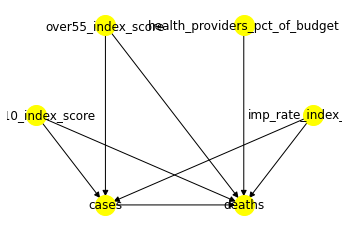

In [31]:
dotgraph=""" digraph {over10_index_score -> cases;over10_index_score -> deaths; imp_rate_index_score -> cases; imp_rate_index_score -> deaths; health_providers_pct_of_budget -> deaths;  over55_index_score -> deaths; cases -> deaths; over55_index_score -> cases;}
"""
new_model=CausalModel(data = main,
        treatment="health_providers_pct_of_budget",
        outcome=["deaths"],
        graph=dotgraph)
new_model.view_model()

In [32]:
identified_estimand = new_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                             
─────────────────────────────────(Expectation(deaths|over10_index_score,over55
d[health_providers_pct_of_budget]                                             

                                         
_index_score,imp_rate_index_score,cases))
                                         
Estimand assumption 1, Unconfoundedness: If U→{health_providers_pct_of_budget} and U→deaths then P(deaths|health_providers_pct_of_budget,over10_index_score,over55_index_score,imp_rate_index_score,cases,U) = P(deaths|health_providers_pct_of_budget,over10_index_score,over55_index_score,imp_rate_index_score,cases)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [33]:
estimate = new_model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)
print(estimate)
print("Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                             
─────────────────────────────────(Expectation(deaths|over10_index_score,over55
d[health_providers_pct_of_budget]                                             

                                         
_index_score,imp_rate_index_score,cases))
                                         
Estimand assumption 1, Unconfoundedness: If U→{health_providers_pct_of_budget} and U→deaths then P(deaths|health_providers_pct_of_budget,over10_index_score,over55_index_score,imp_rate_index_score,cases,U) = P(deaths|health_providers_pct_of_budget,over10_index_score,over55_index_score,imp_rate_index_score,cases)

## Realized estimand
b: deaths~health_providers_pct_of_budget+over10_index_score+over55_index_score+imp_rate_index_score+cases+health_providers_pct_of_budget*over10_index_score+h

In [34]:
res_random=new_model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:0.00301717784635655
New effect:0.0022118631560475166



In [36]:
alt_dotgraph="digraph {health_providers_pct_of_budget -> cases;cases -> deaths;health_providers_pct_of_budget -> deaths; over55_index_score -> deaths;}"
alt_model=CausalModel(data = main,
        treatment="health_providers_pct_of_budget",
        outcome=["deaths"],
        graph=alt_dotgraph)
identified_estimand = alt_model.identify_effect(proceed_when_unidentifiable=True)
alt_estimate = alt_model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)
print(alt_estimate)
print("Estimate is " + str(alt_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                        
─────────────────────────────────(Expectation(deaths|over55_index_score))
d[health_providers_pct_of_budget]                                        
Estimand assumption 1, Unconfoundedness: If U→{health_providers_pct_of_budget} and U→deaths then P(deaths|health_providers_pct_of_budget,over55_index_score,U) = P(deaths|health_providers_pct_of_budget,over55_index_score)

## Realized estimand
b: deaths~health_providers_pct_of_budget+over55_index_score+health_providers_pct_of_budget*over55_index_score
Target units: ate

## Estimate
Mean value: 0.00012342953417443514
p-value: [0.30046018]
### Conditional Estimates
__categorical__over55_index_score
(0.049, 0.2]    0.005064
(0.2, 0.33]     0.001604
(0.33, 0.37]   -0.000050
(0.37, 0.46]   -0.001349
(0.46, 1.0]    -0.005639
dtype: f

In [37]:
alt_estimate = alt_model.estimate_effect(alt_model.identify_effect(proceed_when_unidentifiable=True),
        method_name="backdoor.linear_regression", test_significance=True
)
print(alt_estimate)
print("Estimate is " + str(alt_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                        
─────────────────────────────────(Expectation(deaths|over55_index_score))
d[health_providers_pct_of_budget]                                        
Estimand assumption 1, Unconfoundedness: If U→{health_providers_pct_of_budget} and U→deaths then P(deaths|health_providers_pct_of_budget,over55_index_score,U) = P(deaths|health_providers_pct_of_budget,over55_index_score)

## Realized estimand
b: deaths~health_providers_pct_of_budget+over55_index_score+health_providers_pct_of_budget*over55_index_score
Target units: ate

## Estimate
Mean value: 0.00012342953417443514
p-value: [0.30046018]
### Conditional Estimates
__categorical__over55_index_score
(0.049, 0.2]    0.005064
(0.2, 0.33]     0.001604
(0.33, 0.37]   -0.000050
(0.37, 0.46]   -0.001349
(0.46, 1.0]    -0.005639
dtype: f

In [46]:
final_dotgraph="digraph {INDEX_SCORE -> total_inmate_deaths;}"
final_model=CausalModel(data = main,
        treatment="INDEX_SCORE",
        outcome=["total_inmate_deaths"],
        graph=final_dotgraph)
final_identified_estimand = final_model.identify_effect(proceed_when_unidentifiable=True)
final_estimate = final_model.estimate_effect(final_identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)
print(final_estimate)
print("Estimate is " + str(final_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                         
──────────────(Expectation(total_inmate_deaths))
d[INDEX_SCORE]                                  
Estimand assumption 1, Unconfoundedness: If U→{INDEX_SCORE} and U→total_inmate_deaths then P(total_inmate_deaths|INDEX_SCORE,,U) = P(total_inmate_deaths|INDEX_SCORE,)

## Realized estimand
b: total_inmate_deaths~INDEX_SCORE
Target units: ate

## Estimate
Mean value: 25.660439137529927
p-value: [0.00400316]

Estimate is 25.660439137529927


In [49]:
res_placebo=final_model.refute_estimate(final_identified_estimand, final_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:25.660439137529927
New effect:-0.9580644365705058
p value:0.44999999999999996



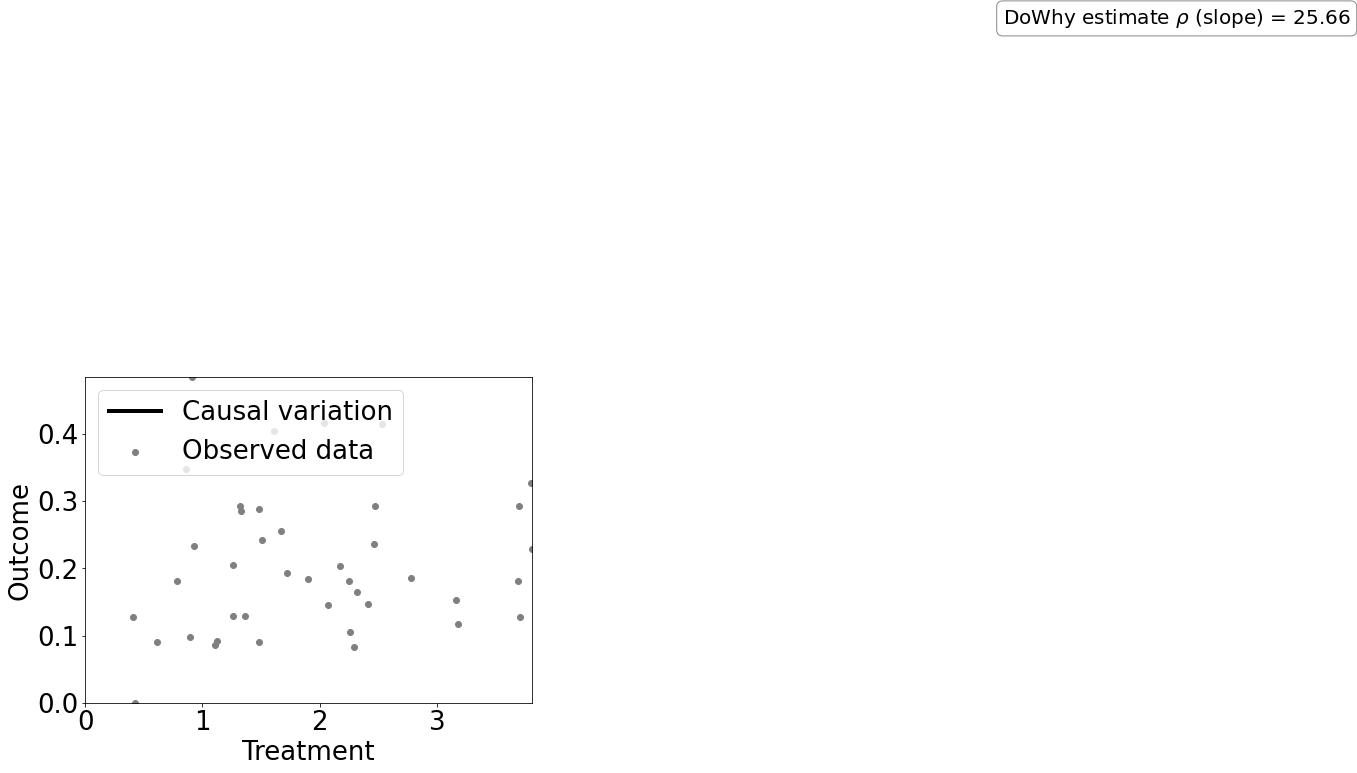

In [50]:
dowhy.plotter.plot_causal_effect(final_estimate, main["INDEX_SCORE"], main["deaths"])

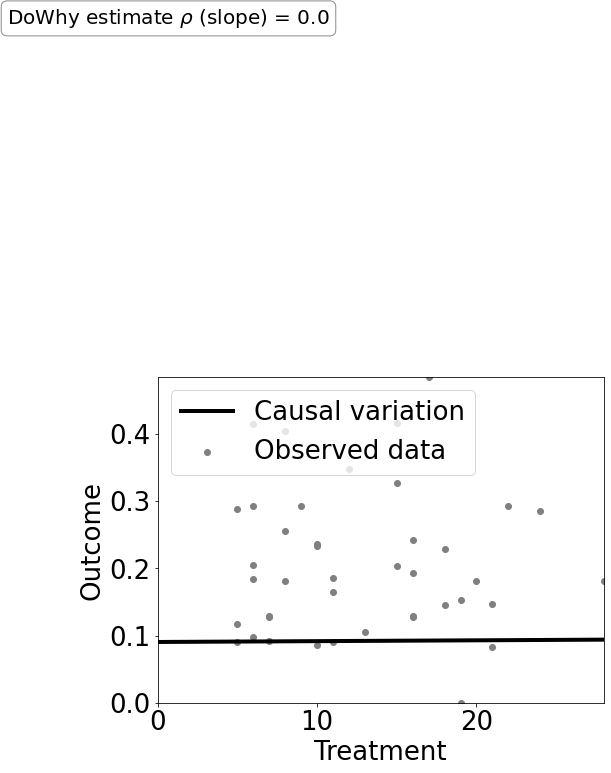

In [38]:
dowhy.plotter.plot_causal_effect(alt_estimate, main["health_providers_pct_of_budget"], main["deaths"])

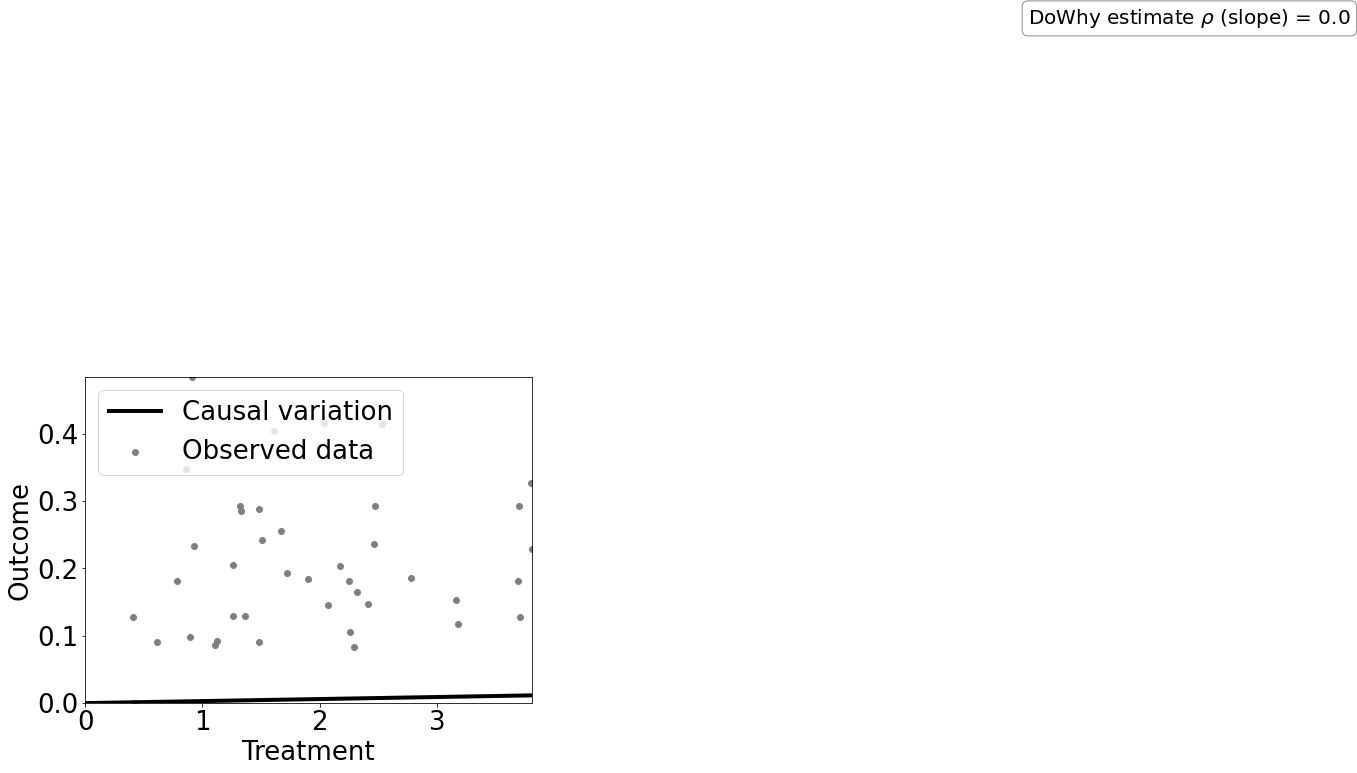

In [39]:
dowhy.plotter.plot_causal_effect(estimate, main["INDEX_SCORE"], main["deaths"])

In [21]:
res_placebo=new_model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.00301717784635655
New effect:9.81635081738097e-05
p value:0.48



In [ ]:
#Discarded
def plots_and_corrs(df,minimum_correlation=.2):
    cor=df.corr()
    df_elements=list(cor.index)
    cor_dict={name:{element:cor[name][element] for element in df_elements} for name in df_elements}
    #{name:sorted(list(cor_dict[name].items()),key=lambda x:(abs(x[1])))[::-1][1:4] for name in df_elements}
    highest_correlations={name:[i for i in sorted(list(cor_dict[name].items()),key=lambda x:(abs(x[1]))) if minimum_correlation<abs(i[1])<1][::-1][:3] for name in df_elements}
    for k in list(highest_correlations.keys()):
        if len(highest_correlations[k])==0:
            del highest_correlations[k]
    for key in list(highest_correlations.keys()):
        print("The best correlations between "+key+" and other variables in the dataset are")
        print(highest_correlations[key])
        df[key].plot(title=key,kind="hist")
        plt.show()
#plots_and_corrs(PPPdf)
#highest_correlations